Synthlabs Train split data assessmet with **HAL16Q** questions

In [1]:
import pandas as pd

In [2]:
import os, json, time

In [3]:
data = pd.read_csv("synthlabs_data/synthlabs_dialogues_train.csv")
data.head()

,model,reasoning_effort,dialogue,score,parent_id,persona_id,dialogue_id
0,Meta-Llama-3.1-405B-Instruct,NaN,"P: Marcela Soto. Nice to meet you, Doctor. Sor...",0,0,0,0
1,gpt-5-mini,high,"P: Hola, doctor. Thank you for seeing me. I'm ...",0,0,0,1
2,gpt-5-nano,high,"P: Good morning, Doctor. I’m Marcela Soto, 45,...",0,0,0,2
3,gpt-4.1-nano,NaN,"P: Hola, doctor. Gracias por atenderme hoy. La...",0,0,0,3
4,qwen2.5:14b,NaN,P: Dr. Patel! It’s so nice to see you again. I...,0,0,1,4


# TinyAgent

## TinyAgentOSS Local

In [4]:
from openai import OpenAI
import random

class TinyAgentOSS:

    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 20072
        self.debug = False
        self.reasoning_effort = "low"
        self.port = random.choice([11434])
        self.client = OpenAI(
            base_url=f"http://localhost:{self.port}/v1",  # Local Ollama API
            api_key="ollama"                       # Dummy key
        )
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')

    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.add_system_message(f"Reasoning: {reasoning_effort}")

    def call(self, prompt="", response_format="text"):
        if prompt:
            self.add_user_message(prompt)

        # if self.model == "gpt-5":
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages,
            timeout=600,
            response_format={
            "type": response_format
          },
        )
        reply = response.choices[0].message.content
        if self.debug:
            print(reply)

        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_reply(self):

        reply = self.call()

        return reply

    def call_json(self):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call()
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            with open("errors.txt", "a") as f:
                f.write(f"\n-------\nNot JSON structure: \n{reply}\n")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("[call_json_hard] Error parsing JSON")
            return None


## TinyAgent with API

In [6]:
import os, getpass
import json
import tiktoken
from openai import OpenAI

def _set_env(var: str, reset=False):
    if not os.environ.get(var) or reset:
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

class TinyAgent:
    
    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "high"
        self.temperature = 1
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')
        self.client = OpenAI()
            
    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = self.client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = self.client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

# HAL16Q-Judge

In [7]:
## 14 Reasons Why

def _build_prompt_HLJ(conversation):
    return """# Human vs. AI Speaking-Style Likert-Type Numeric Rating Scale

The 16 statements below describe characteristics of human-likeness in a speaker’s dialogue within a Turing test scenario. Please rate the speaking style of Patient P, based only on their portion of the provided dialogue, using the following scale:

- Score 5: The trait is conclusively present (high agreement with the statement).
- Score 3: The trait is somewhat present, not relevant, or there is only medium agreement.
- Score 1: The trait is mostly absent (low agreement with the statement).

Rate it low if you have any reason to do so. If uncertain, err on the side of a lower rating.

Only consider Patient P's dialogue; ignore all statements or actions by Doctor D.

**Likert Statements**

1. Keeps replies brief and casual without over-explaining.
2. Uses emojis, emoticons, and playful elongations.
3. Makes niche cultural references from personal memory and assumes shared context.
4. Uses lowercase texting style.
5. Shows small typos, uneven punctuation, and informal grammar typical of quick texting.
6. Builds on the other person's message and context.
7. Uses natural, idiomatic phrasing.
8. Shows reciprocity by asking natural, context-aware follow-up questions that advance the chat.
9. Uses casual, playful humor.
10. Admits not knowing and asks to learn instead of inventing details.
11. References immediate context or recent activity.
12. Uses casual slang, abbreviations, and shorthand naturally.
13. Explains choices with simple personal reasons and constraints.
14. Stays on topic and steers the conversation rather than mirroring or deflecting.
15. Sometimes shows impatience and ends the chat quickly with a brief nicety.
16. Gives direct answers about self with concrete personal details.

## Required Input

You must supply Patient P's dialogue only (exclude all of Doctor D’s lines) to allow the system to perform this evaluation.

## Output Format and Verbosity

Return a valid JSON object containing ratings for each statement, with statement numbers (1–16). The value for each statement must be an integer from 1 to 5. Do not include any text or commentary outside the JSON object.

- Limit your output to the JSON object only, with no introductory or concluding remarks.
- Ensure the JSON object is compact and free of extra whitespace or lines.
- Prioritize providing a complete, actionable evaluation for all 16 statements within this format cap.

Output format:
```json
{
  "likert_evaluation": {
      "1": INT(1-5),
      ...
      "7":  INT(1-5)
      "8":  INT(1-5),
      ...
      "16":  INT(1-5),
  }
}
```

Error message format:
```json
{
    "error": "message..."
}
```

## Input dialogue:
<dialogue>
"""+conversation+"\n\n"

In [8]:
import re
import statistics
import json
import numpy as np

# coefficient of variation (CV)
#
def coeff_var(dialogue, speakers=['D', 'P'], target='P'):
    """
    CV = 0: no variation (all values identical).
    CV < 0.1: very low variation.
    CV ≈ 0.1–0.3: moderate variation.
    CV > 0.5: high variation or data widely spread.
    """
    s1, s2 = speakers
    
    pattern = rf'^({s1}|{s2}):\s*(.*?)(?=^(?:{s1}|{s2}):|\Z)'
    matches = re.findall(pattern, dialogue, flags=re.S | re.M)
    
    Speaker1, Speaker2 = [], []
    target_lens = []
    for speaker, line in matches:
        cleaned = line.strip().replace('\u2019', "'").replace('\u2014', '—')
        if speaker == target:
            Speaker2.append(cleaned)
            target_lens.append(len(cleaned.split()))
        else:
            Speaker1.append(cleaned)
    try:
        cv = statistics.stdev(target_lens)/statistics.mean(target_lens)
    except:
        cv = 0
    return cv, len(target_lens)


def get_judge_choices(conversation, model, reasoning_effort="low", debug=False):
    try:
        if "oss" in model:
            agent = TinyAgentOSS(model)
        else:
            agent = TinyAgent(model)
        agent.set_debug(debug)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_build_prompt_HLJ(conversation))
        result = agent.call_json()
        if debug:
            print(f"Response from get_judge_choices {result}./nType: {type(result)}")
        return extract_likert_integers(result, debug)
    except Exception as e:
        print(f"get_judge_choices error: {e}")
        return None
    
def extract_likert_integers(data, debug=False):
    key = list(data.keys())[0]
    eval_dict = data[key]
    if debug:
        print(f"extract_likert_integers dict found: {eval_dict}")
    values = list(eval_dict.values())
    if len(values) != 16:
        return None
    return values

def clean_dialogue(text):
    if pd.isna(text):
        return text
    # Replace multiple newlines with one
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'---', '', text)
    text = re.sub(r'[ \t]+', ' ', text)
    # Remove everything before the first "P:"
    text = re.sub(r'^.*?P:', 'P:', text, flags=re.DOTALL).strip()
    # text += '\n</dialogue>\n'
    return text

def extract_dialogue(text):
    parts = text.split("\n---\n", 2)
    return parts[2].strip() if len(parts) == 3 else ""

with open("HAL16_judge_weights.json", "r") as f:
    parameters = json.load(f)

w_final = np.array(parameters["w"])
b_final = parameters["b"]

def hal16_score(arr):
    arr = np.array(arr)
    return float(arr.dot(w_final) + b_final)

## Judge Turing data

In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row_single( row, 
                        model_name="gpt-oss:120b", 
                        reasoning_effort="high", 
                        id_column="dialogue_id", 
                        root_key = "likert_evaluation",
                        debug = False
                        ):
    """
    This method is specifically built for evaluating the Turing test dataset, two dialogue at a time.
    Input: row containing two dialogue
    Output: Same row, with few added columns
    """
    idx = row[id_column]
    try:
        start_time = time.time()
        conversation = clean_dialogue(str(row["dialogue"]))
        cv, dialogue_len = coeff_var(conversation, ['P', 'D'], 'P')

        result = get_judge_choices(conversation, model_name, reasoning_effort, debug)

        if debug:
            print(f"process_row_double A: {result}")
        
        tr = row.copy()
        score_mean = sum(result)/len(result)
        tr[root_key] = result
        tr["hal16_score"] = hal16_score(result)
        tr[root_key+"_mean"] = score_mean
        tr["cv"] = cv
        tr["elapsed_time"] = time.time() - start_time

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_double Error: {e}, {id_column}: {idx}")
        return None

In [36]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel(data: pd.DataFrame,
                        process_method,
                        num_workers: int = 4,
                        output_path: str = "output.csv",
                        model_name: str = "gpt-5-mini",
                        reasoning_effort: str = "low",
                        print_every: int = 1,
                        id_column: str = "game_id",
                        root_key: str = "likert_evaluation"
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data[id_column].isin(output_csv[id_column])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print("File not found, creating new file.")
        results = []

    tasks = [row for _, row in data.iterrows()]
    num_workers = min(num_workers, len(data))
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    if len(tasks) == 0:
        print(f"No tasks to do, exiting.")
        return

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_method, row, model_name, reasoning_effort, id_column, root_key) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")

    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

## Single test

In [11]:
process_row_single(data.iloc[5], model_name="gpt-5")

{'model': 'Meta-Llama-3.1-405B-Instruct',
 'reasoning_effort': nan,
 'dialogue': "P: Ah, thank goodness I made it on time, Doctor. Traffic was dreadful today.\nD: Good morning, Emily. Yes, traffic can be a challenge. How have you been feeling since our last visit?\nP: Honestly, a bit of a rollercoaster. The numbness in my legs has gotten worse. It's like pins and needles, but it doesn't go away, and I'm getting worried it'll affect my rock climbing. I know it sounds crazy, but that's my sanity, you know?\nD: I understand. Your rock climbing is important to you, and we want to keep you doing what you love. Can you tell me more about these numbness episodes? How often are they happening, and have you noticed any triggers?\nP: It's almost every day now. Sometimes, it's just when I wake up, and other times it's after I've been sitting for a while. And the weirdest part is, when I'm stressed or anxious, it's like my legs are on fire. Well, not on fire, exactly, but it feels like ants are cr

# Run inference

In [37]:
output_dir = "synthlabs_data"
output_filename = "synthlabs_dialogues_train"

!ls $output_dir

prompts_synthlabs_dialogues_test.csv
prompts_synthlabs_dialogues_train.csv
synthlabs_dialogues_test.csv
synthlabs_dialogues_train.csv
synthlabs_dialogues_train_scored_gpt-5.csv
synthlabs_dialogues_train_scored_gpt-5-mini.csv
synthlabs_test_dialogues_seven_models.json
synthlabs_train_dialogues_seven_models.json


Completed:

    Model, Reasoning Effort, Completed
- gpt-oss:20b, high, ✅
- gpt-oss:120b, high, 
- gpt-5-mini, high, 
- gpt-5, high, 

In [16]:
model_name = "gpt-5"
reasoning_effort = "high"
id_column = "dialogue_id"
root_key = "likert_evaluation"
num_workers = 4 if "oss" in model_name else 500

output_path = f"{output_dir}/{output_filename}_scored_{model_name}.csv".replace(":", "-")
print(output_path, num_workers)

synthlabs_data/synthlabs_dialogues_train_scored_gpt-5.csv 250


In [38]:
process_parallel(data,
                process_row_single,
                num_workers = num_workers,
                output_path = output_path,
                model_name = model_name,
                reasoning_effort = reasoning_effort,
                print_every = 10,
                id_column = id_column,
                root_key = root_key
            )

File exists. Loading synthlabs_data/synthlabs_dialogues_train_scored_gpt-5.csv
Starting generation after 7200. Remaining data: 0
Total task: 0 | Number of Workers: 0
No tasks to do, exiting.


In [51]:
output_path = 'synthlabs_data/synthlabs_dialogues_train_scored_gpt-5.csv'

'synthlabs_data/synthlabs_dialogues_train_scored_gpt-5.csv'

In [39]:
import pandas as pd

In [40]:
output = pd.read_csv(output_path)
output.columns

Index(['model', 'reasoning_effort', 'dialogue', 'score', 'parent_id',
       'persona_id', 'dialogue_id', 'likert_evaluation', 'hal16_score',
       'likert_evaluation_mean', 'cv', 'elapsed_time'],
      dtype='object')

In [41]:
len(output)

7200

In [42]:
output.head()

,model,reasoning_effort,dialogue,score,parent_id,persona_id,dialogue_id,likert_evaluation,hal16_score,likert_evaluation_mean,cv,elapsed_time
0,gpt-5-nano,high,"P: Good morning, Doctor. I’m Elliot Meyer, a 2...",0,5,22,88,"[2, 1, 1, 1, 1, 5, 5, 1, 1, 3, 5, 1, 5, 5, 1, 5]",-3.819813,2.6875,0.421407,29.538663
1,gpt-5-nano,high,"P: Good morning, Doctor. Evelyn O'Sullivan her...",0,13,53,212,"[3, 1, 1, 1, 1, 5, 5, 5, 2, 3, 5, 1, 5, 5, 1, 5]",-4.464647,3.0625,0.322045,37.746200
2,qwen2.5:14b,NaN,"P: Well, Doc, it’s nice to see you again. Thes...",0,15,61,244,"[5, 1, 1, 1, 2, 5, 5, 5, 4, 3, 5, 4, 4, 5, 2, 5]",-2.376784,3.5625,0.477937,37.001775
3,gpt-5,medium,"P: Good morning, Doctor. I brought my glucose ...",0,12,50,203,"[1, 1, 2, 1, 1, 5, 5, 5, 4, 3, 5, 2, 5, 5, 1, 5]",-8.555452,3.1875,0.563651,38.296150
4,gpt-4.1-nano,NaN,"P: Well, hello there! I hope you’re having a g...",0,7,31,124,"[1, 1, 1, 1, 1, 5, 5, 5, 4, 3, 5, 1, 5, 5, 1, 5]",-7.835976,3.0625,0.212766,40.688015


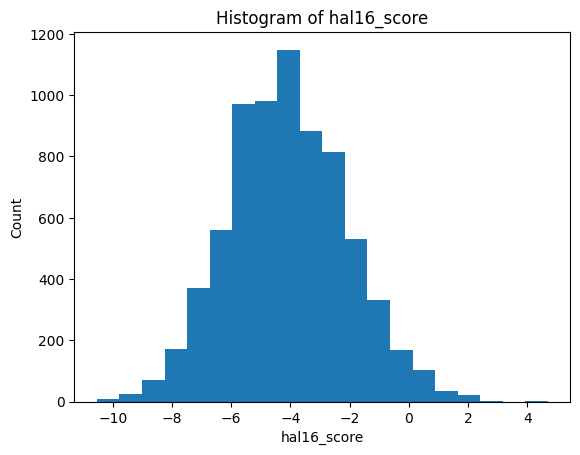

In [43]:
import matplotlib.pyplot as plt

plt.hist(output["hal16_score"], bins=20)
plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histogram of hal16_score")
plt.show()

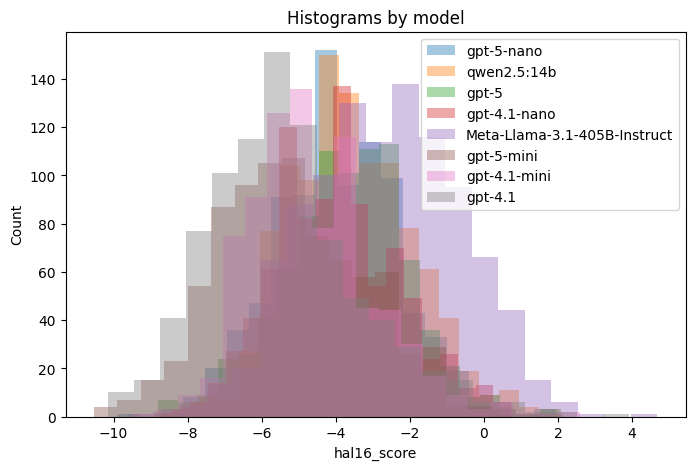

In [44]:
import matplotlib.pyplot as plt

models = output["model"].unique()

plt.figure(figsize=(8, 5))

for m in models:
    subset = output[output["model"] == m]["hal16_score"]
    plt.hist(subset, bins=20, alpha=0.4, label=m)

plt.xlabel("hal16_score")
plt.ylabel("Count")
plt.title("Histograms by model")
plt.legend()
plt.show()


In [45]:
!pip install -q seaborn

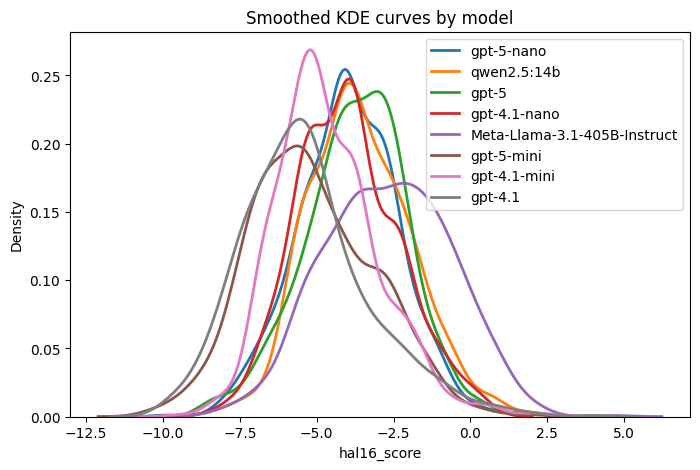

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

models = output["model"].unique()

plt.figure(figsize=(8, 5))

for m in models:
    subset = output[output["model"] == m]["hal16_score"]
    sns.kdeplot(subset, fill=False, linewidth=2, label=m)

plt.xlabel("hal16_score")
plt.ylabel("Density")
plt.title("Smoothed KDE curves by model")
plt.legend()
plt.show()


In [49]:
std_val = output["hal16_score"].std()
mean = output["hal16_score"].mean()
print(mean, std_val)

-4.091943139100619 1.9990357774634335


In [48]:
means = output.groupby("model")["hal16_score"].mean().sort_values(ascending=False)
print(means)

model
Meta-Llama-3.1-405B-Instruct   -2.692108
qwen2.5:14b                    -3.594146
gpt-5                          -3.720027
gpt-5-nano                     -3.970540
gpt-4.1-nano                   -3.999402
gpt-4.1-mini                   -4.642019
gpt-5-mini                     -5.159688
gpt-4.1                        -5.380247
Name: hal16_score, dtype: float64


<Figure size 800x500 with 0 Axes>

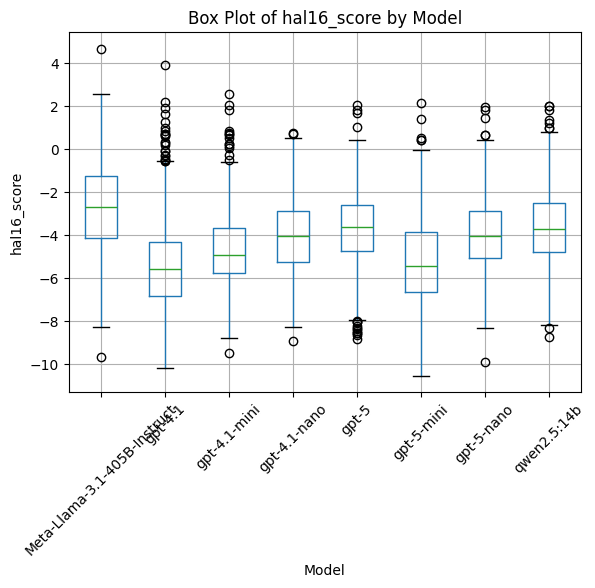

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
output.boxplot(column="hal16_score", by="model")
plt.title("Box Plot of hal16_score by Model")
plt.suptitle("")
plt.xlabel("Model")
plt.ylabel("hal16_score")
plt.xticks(rotation=45)
plt.show()
